In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar

import lal
import lalsimulation as lalsim

/tmp/ipykernel_62019/3793083812.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


NR file. Path to h5 file.

In [3]:
filepath = 'chombo/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
f = h5py.File(filepath, 'r')

Set binary extrinsic parameters. It is important for this calculation that the inclination angle is set to 0.

In [4]:
inclination = 0.0                   # radians
distance = 250.0e6 * lal.PC_SI      # meters
phiRef = 0.0                        # radians

Set binary intrinsic parameters.

In [5]:
mtotal = 40.0                       # solar masses

m1 = f.attrs['mass1']               # code units
m2 = f.attrs['mass2']

mass_1 = m1 * mtotal / (m1 + m2)    # solar masses
mass_2 = m2 * mtotal / (m1 + m2)

m1SI = mass_1 * lal.MSUN_SI         # kg
m2SI = mass_2 * lal.MSUN_SI

spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(0., mtotal, filepath)
s1x, s1y, s1z = spins[0], spins[1], spins[2]
s2x, s2y, s2z = spins[3], spins[4], spins[5]

Set time series parameters.

In [6]:
sampling_frequency = 4096.0         # Hz
deltaT = 1.0 / sampling_frequency   # seconds
fRef = 0.                           # Hz

# generate the whole NR waveform from beginning
f_lower = f.attrs['f_lower_at_1MSUN']/mtotal  
fStart = f_lower

Close the data file.

In [7]:
f.close()

Use `lalsim` to generate the waveform polarisations for the injection.

In [8]:
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

approx = lalsim.NR_hdf5

inject_l_modes=[2]
ModeArray = lalsim.SimInspiralCreateModeArray()
for mode in inject_l_modes:
    lalsim.SimInspiralModeArrayActivateAllModesAtL(ModeArray, mode)

lalsim.SimInspiralWaveformParamsInsertModeArray(params, ModeArray)

h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

Plot.

t0=0.00e+00, f0=2.66e+01, t1=5.48e-02, f1=2.74e+01


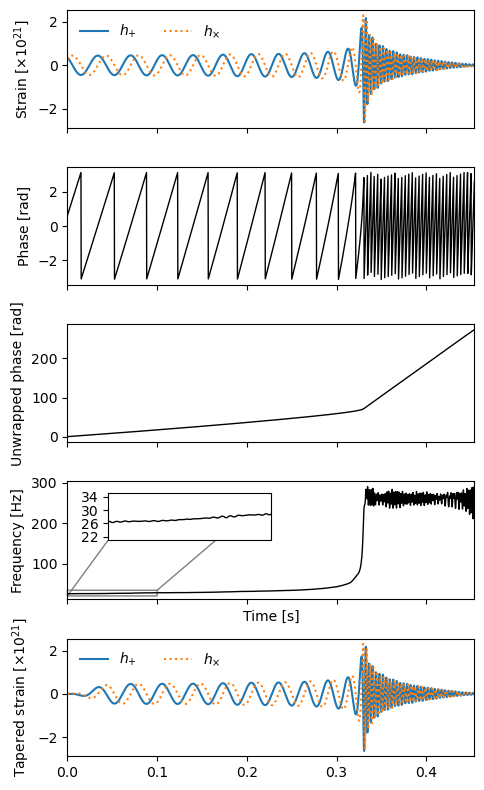

(0.0, 0.054766221574007165)

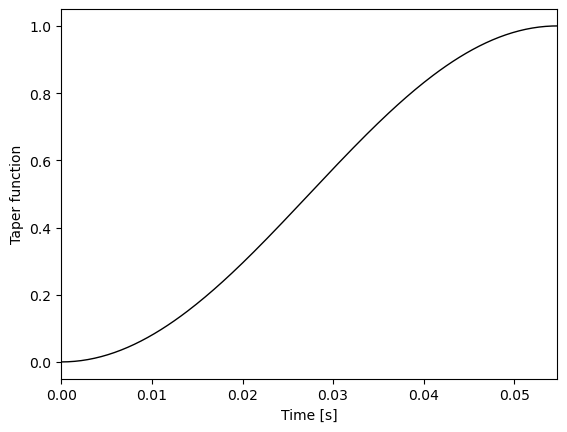

In [10]:
fig, axes = plt.subplots(nrows=5, sharex=True, figsize=(5, 8))

axes[0].plot(times, 1.0e21*h_p.data.data, ls='-', label=r'$h_{+}$')
axes[0].plot(times, 1.0e21*h_c.data.data, ls=':', label=r'$h_{\times}$')
axes[0].set_ylabel(r'Strain [$\times 10^{21}$]')
axes[0].set_xlim(times[0], times[-1])
axes[0].legend(loc='upper left', frameon=False, ncols=2)

phase = np.arctan2(h_c.data.data, h_p.data.data)
axes[1].plot(times, phase, 'k-', lw=1)
axes[1].set_ylabel('Phase [rad]')

unwrapped_phase = np.unwrap(phase)
axes[2].plot(times, unwrapped_phase, 'k-', lw=1)
axes[2].set_ylabel('Unwrapped phase [rad]')

unwrapped_phase_interp = UnivariateSpline(times, unwrapped_phase, k=3, s=0)
#frequency = np.gradient(unwrapped_phase, h_p.deltaT) / (2.0 * np.pi)
omega_interp = unwrapped_phase_interp.derivative() 
frequency = omega_interp(times) / (2.0 * np.pi)
axes[3].plot(times, frequency, 'k-', lw=1)
axes[3].set_xlabel('Time [s]')
axes[3].set_ylabel('Frequency [Hz]')

# inset Axes....
x1, x2, y1, y2 = 0.0, 0.1, 21.0, 35.0  # subregion of the original image
axins = axes[3].inset_axes(
    [0.1, 0.5, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[], yticks=np.arange(22., 36.1, 4.))
axins.plot(times, frequency, 'k-', lw=1)
axes[3].indicate_inset_zoom(axins, edgecolor="black")

# root finding to determine the time range t0 to t1 over which to taper
safety = 0.5
sol = root_scalar(lambda t1: (1+safety)*(1./t1)-omega_interp(t1)/(2.0*np.pi),
                    x0 = 0.1, 
                    bracket=[0.01, 0.3])
t0, t1 = 0., sol.root
f0, f1 = omega_interp(t0)/(2.0*np.pi), omega_interp(t1)/(2.0*np.pi)
print(f"{t0=:.2e}, {f0=:.2e}, {t1=:.2e}, {f1=:.2e}")

def window(times, t0, t1):
    taper = np.ones_like(times)
    mask = (times >= t0) & (times <= t1)
    taper[mask] = 0.5 * (1 - np.cos(np.pi * (times[mask] - t0) / (t1 - t0)))
    return taper

taper = window(times, t0, t1)

tapered_hp = h_p.data.data * taper
tapered_hc = h_c.data.data * taper
axes[4].plot(times, 1.0e21*tapered_hp, ls='-', label=r'$h_{+}$')
axes[4].plot(times, 1.0e21*tapered_hc, ls=':', label=r'$h_{\times}$')
axes[4].set_ylabel(r'Tapered strain [$\times 10^{21}$]')
axes[4].set_xlim(times[0], times[-1])
axes[4].legend(loc='upper left', frameon=False, ncols=2)

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(times, taper, 'k-', lw=1)
plt.xlabel('Time [s]')
plt.ylabel('Taper function')
plt.xlim(t0, t1)